# UMAP reduction of COI per timepoint

The setup of this notebooks is to transform the data with UMAP and color the manifold according to labels and fluorescence intensity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load, correlation, umap_all
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
from sklearn.preprocessing import robust_scale
from sklearn.decomposition import PCA
import uuid

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=6, threads_per_worker=1, silence_logs=False)
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:34703
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40037'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:39295'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:43223'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:44257'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:40847'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:33789'
distributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:34149', name: 4, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:34149
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:43367', name: 5, memory: 0

In [5]:
client.cluster

In [7]:
samples = None
# samples = pandas.read_csv("data/selected_samples.csv")
data_dd = e_load.load_raw_ideas_dir_dask(
    Path("/data/weizmann/EhV/high_time_res"), Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"),
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"), 
    samples, "Low/*.cif")
data_dd = data_dd.map_partitions(e_load.remove_unwanted_features)
data_dd = data_dd.map_partitions(e_load.tag_columns)
data_dd = data_dd.map_partitions(e_load.clean_column_names)
data_dd = data_dd.map_partitions(e_load.add_merged_col, cols=["meta_group", "meta_timepoint", "meta_replicate", "meta_object_number"])

In [8]:
divisions = sorted(data_dd["meta_timepoint"].unique().compute().values.tolist())
data_dd = data_dd.set_index("meta_timepoint", drop=False, divisions=divisions)#.repartition(npartitions=16)
data_dd.index = data_dd.index.rename("time")

In [9]:
# filter out non-COI cells
data_dd = data_dd.map_partitions(lambda p: p[p["meta_label_coi"]==True])

In [10]:
with open("data/selected_features_low.txt") as fh:
    features = fh.read().split(",")
features.extend(data_dd.partitions[0].compute().filter(regex="meta").columns.values.tolist())

In [11]:
data_dd = data_dd.map_partitions(lambda p: p[features])

In [11]:
def do_robust_scale(df):
    df[df.filter(regex="feat").columns] = robust_scale(df.filter(regex="feat"), quantile_range=(0.1, 0.9))
    return df

# data_dd = data_dd.groupby(["meta_timepoint"]).apply(do_robust_scale)

In [12]:
def get_correlated_features(df, thresh):
    correlation = df.corr().compute()
    var = df.var().compute()
    correlated_features = set()
    for i in range(correlation.shape[0]):
        for j in range(i):
            if abs(correlation.iloc[i, j]) > thresh:
                if var[correlation.columns[i]] >= var[correlation.columns[j]]:
                    colname = correlation.columns[j]
                else:
                    colname = correlation.columns[i]
                correlated_features.add(colname)
                
    return correlated_features

feat_dd = data_dd.map_partitions(lambda p: p.filter(regex="feat"))
data_dd = data_dd.drop(columns=get_correlated_features(feat_dd, 0.9055))

In [12]:
data_dd = data_dd.persist()

# High samples (COI only)

In [13]:
def do_umap(data, **umap_args):
    projector = umap.UMAP(**umap_args)
    
    feat = data.filter(regex="feat")
    # feat = PCA(n_components=20).fit_transform(feat)
    projection = projector.fit_transform(feat)
    projection = pandas.DataFrame(projection, columns=["dim_%d" % i for i in range(1, projector.get_params()["n_components"]+1)])
    return pandas.concat([data[["meta_id"]].reset_index(drop=True), projection], axis=1)

## Compute 2D projection

In [14]:
meta_df = data_dd[["meta_id"]].head(0)
meta_df["dim_1"] = 0.0
meta_df["dim_2"] = 0.0
meta_df.head()

,meta_id,dim_1,dim_2
time,,,


In [15]:
%%time
projected = data_dd.map_partitions(lambda df: do_umap(df, n_components=2, metric="cosine"), meta=meta_df).compute()
projected = projected.reset_index(drop=True)

CPU times: user 15.1 s, sys: 2.32 s, total: 17.5 s
Wall time: 2min 35s


In [16]:
dump(projected, "/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/%s.dat" % uuid.uuid4())

['/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/887adcf4-89e1-49fc-bf26-4017d3e57cbb.dat']

In [17]:
data = data_dd.compute()

In [25]:
client.cluster.close()

distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:40037'
distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:43223'
distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:33789'
distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:39295'
distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:44257'
distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:40847'
distributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:34727', name: 2, memory: 3, processing: 0>
distributed.core - INFO - Removing comms to tcp://127.0.0.1:34727
distributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:42845', name: 0, memory: 3, processing: 10>
distributed.core - INFO - Removing comms to tcp://127.0.0.1:42845
distributed.scheduler - INFO - Remove worker <Worker 'tcp://127.0.0.1:43605', name: 3, memory: 2, processing: 12>
distributed.core - INFO - Removing comms to tcp://127.0.0.1:43605
distributed.scheduler - INFO - Remove worker <Worker 

## Inspect 2D projection (for low viral load)

In [17]:
projected = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/1a4bc965-381c-45ce-8947-12f455882ed8.dat")

In [18]:
projected.head()

,meta_id,dim_1,dim_2
0,Low0R18,9.286595,6.560046
1,Low0R19,-2.487167,7.047264
2,Low0R112,13.445656,10.875971
3,Low0R114,-3.376092,5.872940
4,Low0R126,10.798752,8.466471


In [19]:
df = data.set_index("meta_id").join(projected.set_index("meta_id"))

In [20]:
df.head()

,feat_area_m01,feat_contrast_m09_bf2,feat_gradient_rms_m01_bf,feat_height_m07,feat_height_m06,feat_gradient_rms_m06_ssc,feat_gradient_rms_m07_ch7,feat_gradient_rms_m11_ch11,feat_height_m01,feat_intensity_mc_ch04,...,meta_timepoint,meta_replicate,meta_group,meta_label_coi,meta_label_mcp_neg_psba_pos,meta_label_mcp_pos_psba_pos,meta_label_mcp_pos_psba_neg,meta_label_mcp_neg_psba_neg,dim_1,dim_2
meta_id,,,,,,,,,,,,,,,,,,,,,
Low0R18,24.888889,0.838374,56.374084,4.666667,5.333333,40.187954,30.313007,34.165466,6.000000,-560.492676,...,0,R1,Low,True,True,False,False,False,9.286595,6.560046
Low0R19,55.555557,1.389866,55.626270,4.666667,12.000000,32.673328,28.120426,32.147324,14.000000,-1607.611084,...,0,R1,Low,True,True,False,False,False,-2.487167,7.047264
Low0R112,41.222221,0.588988,54.059586,5.666667,8.666667,37.338764,19.192358,15.194324,7.666667,-968.277771,...,0,R1,Low,True,True,False,False,False,13.445656,10.875971
Low0R114,74.777779,0.975258,46.626072,7.000000,7.333333,24.215099,21.267845,18.301588,13.666667,-1138.748047,...,0,R1,Low,True,True,False,False,False,-3.376092,5.872940
Low0R126,27.444445,0.781494,64.453186,5.000000,4.666667,40.857445,30.200451,45.642982,6.000000,-1243.012207,...,0,R1,Low,True,True,False,False,False,10.798752,8.466471


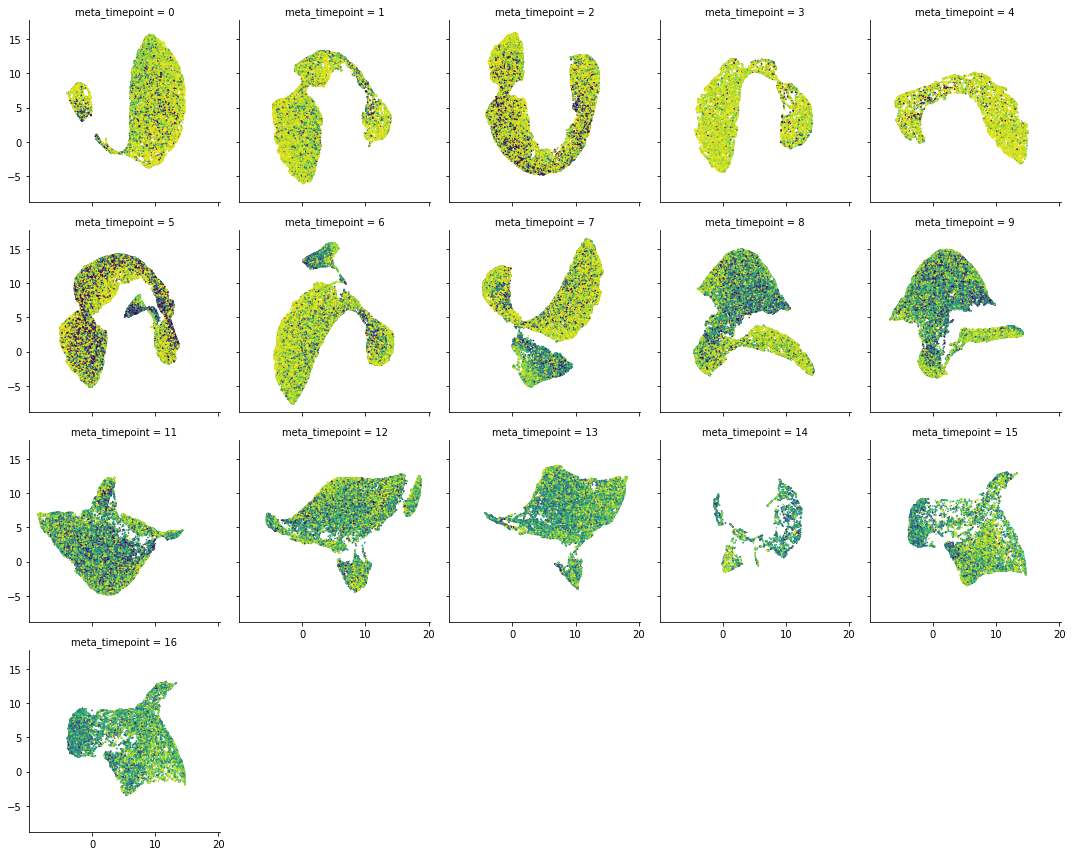

In [23]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_aspect_ratio_intensity_m07_ch7"
norm = matplotlib.colors.Normalize(vmin=df.loc[df["meta_group"] == "Low", feat].quantile(0.05), vmax=df.loc[df["meta_group"] == "Low", feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
# grid.add_legend()

# for handle in grid._legend.legendHandles:
#     handle.set_sizes([30])
#     handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")

In [21]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

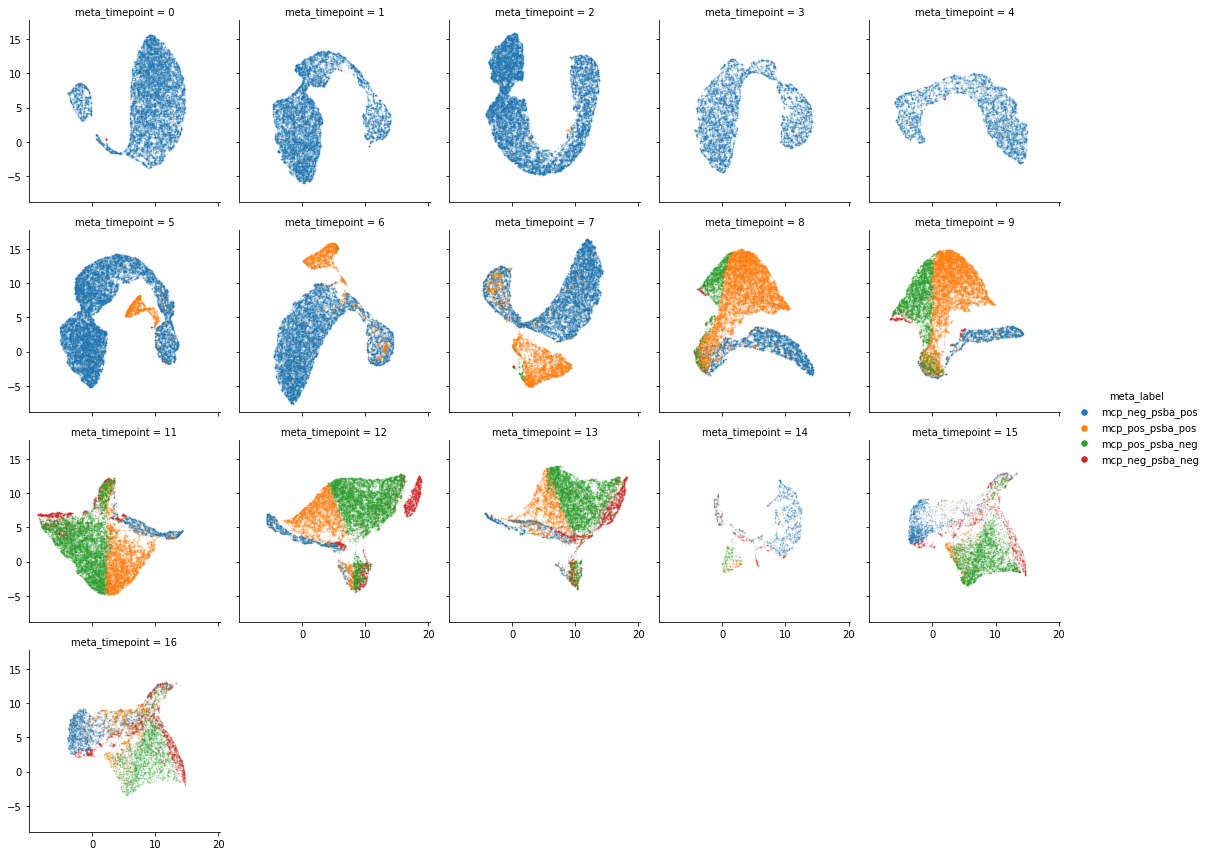

In [24]:
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5, hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
grid = grid.map_dataframe(plt.scatter, x="dim_1", y="dim_2", s=0.2, alpha=0.2)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
plt.savefig("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/assets/thumbs/887adcf4-89e1-49fc-bf26-4017d3e57cbb.jpg")

In [ ]:
grid = seaborn.FacetGrid(col="meta_timepoint", data=df[df["meta_timepoint"].between(8,13)], col_wrap=5, hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"])
grid = grid.map_dataframe(plt.scatter, x="dim_1", y="dim_2", s=0.2, alpha=0.2)
grid.add_legend()

for handle in grid._legend.legendHandles:
    handle.set_sizes([30])
    handle.set_alpha(1.0)
    
plt.savefig("figs/umap/HTR_Low_COI_tp8-13_after_selection_after_correlatino_cosine.png", dpi=150)

In [ ]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_intensity_mc_ch7"
norm = matplotlib.colors.Normalize(vmin=df.loc[df["meta_group"] == "Low", feat].quantile(0.05), vmax=df.loc[df["meta_group"] == "Low", feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df[df["meta_timepoint"].between(8,13)], col_wrap=5)
grid = grid.map_dataframe(scatter, x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")

In [ ]:
selector = (df["meta_timepoint"] == 9) & (df["meta_label"] != "unknown")# & (df["meta_replicate"] == "R1")
corr = df[selector].filter(regex="feat|dim").corr()
corr["dim_1"].abs().sort_values(ascending=False)[:20]

In [ ]:
feat = "feat_intensity_mc_ssc"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/HTR_Low_COI_tp9_after_selection_after_correlation_cosine_intensity_ssc.png", dpi=150)

In [ ]:
seaborn.scatterplot(data=df[selector], x="dim_1", y="dim_2", hue="meta_label", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"], linewidth=0, s=1)
plt.axis("off")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("figs/umap/HTR_Low_COI_tp9_after_selection_after_correlation_cosine_label.png", dpi=150, bbox_inches="tight")

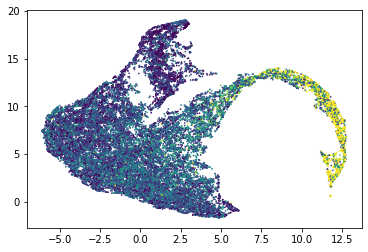

In [46]:
feat = "feat_modulation_m09_bf2"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

In [47]:
corr = df[selector].filter(regex="feat|dim").corr()
corr["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                            1.000000
feat_intensity_mc_ch11           0.573111
feat_gradient_rms_m11_ch11       0.434854
feat_intensity_mc_bf             0.429443
feat_gradient_rms_m09_bf2        0.426863
feat_mean_pixel_m03_ch03         0.412905
feat_modulation_m04_ch04         0.412611
feat_area_m11                    0.374730
feat_intensity_mc_ch7            0.347593
feat_median_pixel_m09_bf2        0.331190
feat_modulation_m07_ch7          0.329960
feat_contrast_m11_ch11           0.287990
feat_length_m03                  0.280725
feat_similarity_m01_ch02_ch03    0.263870
feat_modulation_m03_ch03         0.243950
feat_intensity_mc_ch04           0.243679
feat_aspect_ratio_m11            0.238822
feat_contrast_m04_ch04           0.230832
feat_aspect_ratio_m03            0.222522
feat_gradient_rms_m01_bf         0.213486
Name: dim_2, dtype: float64

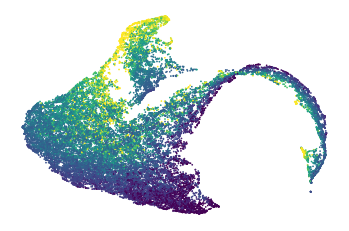

In [54]:
feat = "feat_intensity_mc_ch11"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)
plt.axis("off")
plt.savefig("figs/umap/HTR_Low_COI_tp9_after_selection_cosine_intensity_ch11.png", dpi=150)

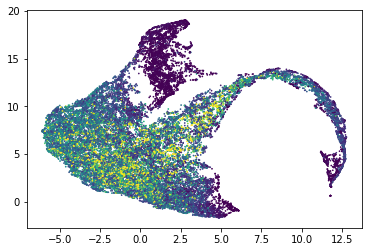

In [55]:
feat = "feat_intensity_mc_ch04"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

## Inspect 2D projection (for high viral load)

In [41]:
projected = load("data/umap/HTR_High_COI_pertp_after_selection.dat")

In [23]:
projected.head()

,meta_id,dim_1,dim_2
0,High1R21,10.957961,12.168464
1,High1R27,6.011353,2.429932
2,High1R211,11.919767,11.583118
3,High1R212,14.035686,4.637509
4,High1R215,12.348964,4.779222


In [24]:
df = data[data["meta_group"] == "High"].set_index("meta_id").join(projected.set_index("meta_id"))

In [26]:
selector = (df["meta_timepoint"]==7) & (df["meta_replicate"]=="R1")

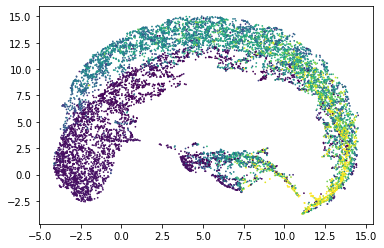

In [27]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch04"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch04"], s=0.5, cmap="viridis", norm=norm)

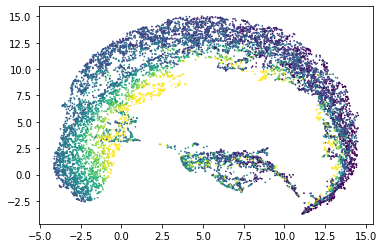

In [28]:
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.05), vmax=df.loc[selector, "feat_Intensity_MC_Ch11"].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, "feat_Intensity_MC_Ch11"], s=0.5, cmap="viridis", norm=norm)

In [29]:
correlation = df.loc[selector].corr()

In [30]:
correlation["dim_1"].abs().sort_values(ascending=False)[:20]

dim_1                                      1.000000
feat_Intensity_MC_Ch7                      0.844948
feat_Intensity_MC_BF2                      0.811694
feat_Intensity_MC_Ch03                     0.786966
feat_Area_M03                              0.737703
feat_Mean Pixel_M09_BF2                    0.684157
feat_Bright Detail Intensity R3_MC_Ch03    0.676615
feat_Width_M03                             0.669502
feat_Bright Detail Intensity R3_MC_Ch7     0.667012
feat_Area_M07                              0.655757
feat_Intensity_MC_Ch04                     0.628908
feat_Length_M03                            0.626408
feat_Height_M03                            0.625846
feat_Length_M04                            0.621126
feat_Height_M04                            0.620931
feat_Width_M04                             0.609384
feat_Width_M07                             0.605571
feat_Bright Detail Intensity R3_MC_Ch04    0.604543
feat_Median Pixel_M04_Ch04                 0.594399
feat_Modulat

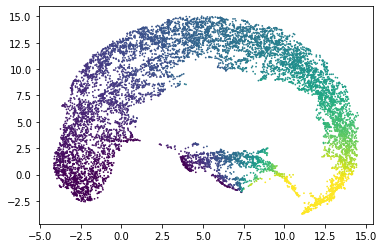

In [31]:
feat = "feat_Intensity_MC_Ch7"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

In [32]:
correlation["dim_2"].abs().sort_values(ascending=False)[:20]

dim_2                                     1.000000
feat_Bright Detail Intensity R3_MC_BF2    0.446727
feat_Bright Detail Intensity R3_MC_SSC    0.421393
feat_Intensity_MC_SSC                     0.415502
feat_Gradient RMS_M03_Ch03                0.415016
feat_Mean Pixel_M06_SSC                   0.411324
feat_Median Pixel_M06_SSC                 0.409924
feat_Max Pixel_MC_SSC                     0.402517
feat_Area_M01                             0.393806
feat_Bright Detail Intensity R3_MC_BF     0.386681
feat_Area_M09                             0.381813
feat_Modulation_M04_Ch04                  0.380943
feat_Contrast_M04_Ch04                    0.364812
feat_Area_MC                              0.358695
feat_Length_M01                           0.354105
feat_Height_M01                           0.353476
feat_Modulation_M09_BF2                   0.352796
meta_label_MCP_NEG_PSBA_POS               0.352488
feat_Length_M09                           0.350090
feat_Height_M09                

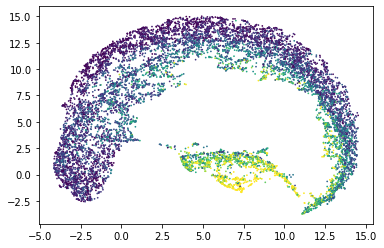

In [33]:
feat = "feat_Bright Detail Intensity R3_MC_BF2"
norm = matplotlib.colors.Normalize(vmin=df.loc[selector, feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
plt.scatter(df.loc[selector, "dim_1"], df.loc[selector, "dim_2"], c=df.loc[selector, feat], s=0.5, cmap="viridis", norm=norm)

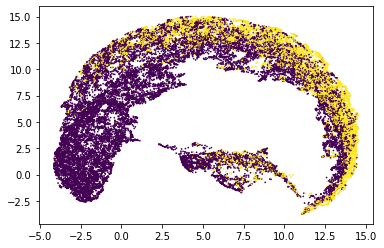

In [36]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_POS_PSBA_NEG"].astype(float), s=0.5)

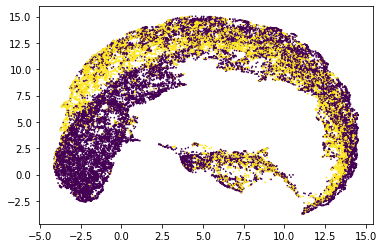

In [37]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_POS_PSBA_POS"].astype(float), s=0.5)

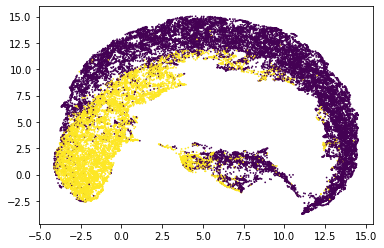

In [38]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_NEG_PSBA_POS"].astype(float), s=0.5)

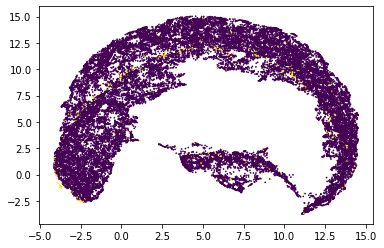

In [39]:
tmp = df[df["meta_timepoint"]==7]
plt.scatter(tmp["dim_1"], tmp["dim_2"], c=df[df["meta_timepoint"]==7]["meta_label_MCP_NEG_PSBA_NEG"].astype(float), s=0.5)

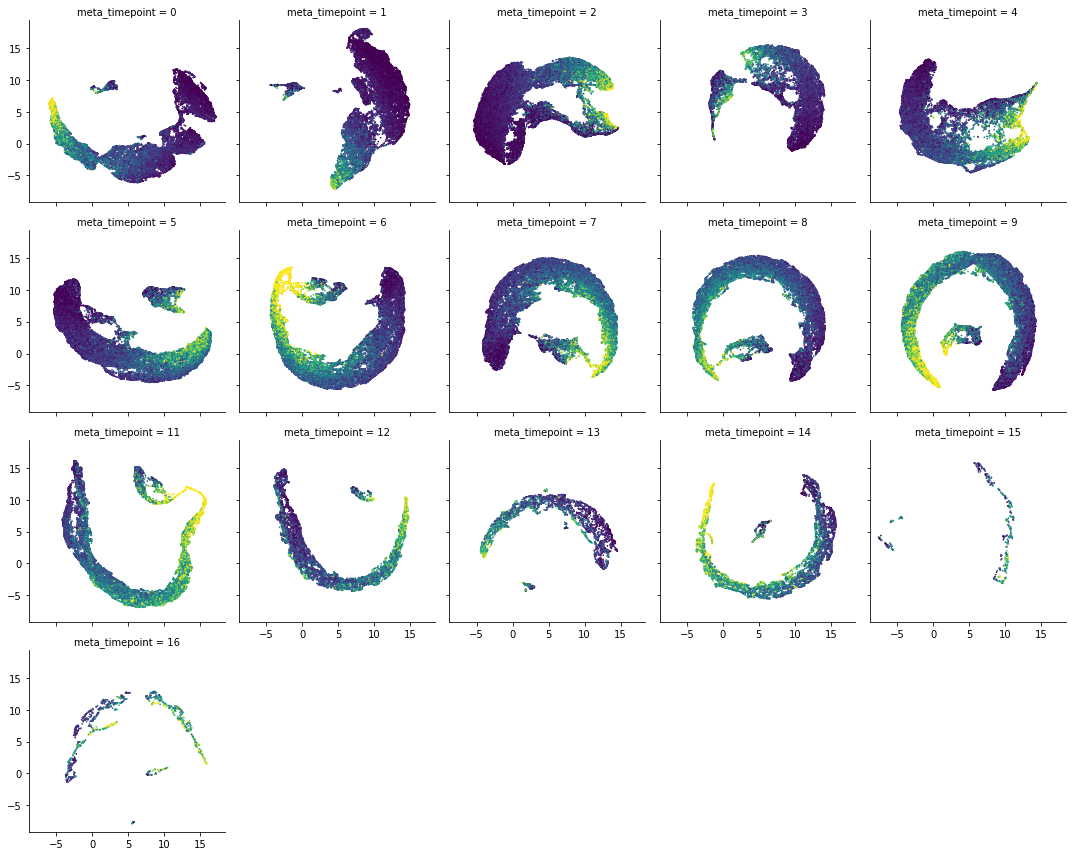

In [43]:
def scatter(x, y, c, **kwargs):
    del kwargs["color"]
    plt.scatter(x, y, c=c, **kwargs)

feat = "feat_Area_M07"
norm = matplotlib.colors.Normalize(vmin=df.loc[df["meta_group"] == "High", feat].quantile(0.05), vmax=df.loc[selector, feat].quantile(0.95))
grid = seaborn.FacetGrid(col="meta_timepoint", data=df, col_wrap=5)
grid = grid.map_dataframe(scatter, 
                x="dim_1", y="dim_2", c=feat, s=0.5, cmap="viridis", norm=norm)
# grid.add_legend()

# for handle in grid._legend.legendHandles:
#     handle.set_sizes([30])
#     handle.set_alpha(1.0)
    
# plt.savefig("figs/umap/HTR_High_ALL_pertp.png")